## **Object Detection Images Data Preparation**
The following code is a notebook showing you how the 'ig02.sframe' used in 'object_detection.ipynb' was created.  This code was adapted from Turi Create's own [data cleaning code](https://github.com/apple/turicreate/blob/master/userguide/object_detection/data-preparation.md). 

In order to run this notebook, you must have downloaded the open source images for the IG02 data set which can be found [here](https://lear.inrialpes.fr/people/marszalek/data/ig02/). We've also provided a bash script to accomplish downloading these images `/utilities/download_ig02.sh`.

This outputs a saved 'SFrame' (Turi Create dataframe object) that includes images and bounding boxes for 1,096 images, which breaks down to 420 cars and 365 bikes and 311 people.

---

Execute each cell one-by-one, by selecting the cell and do one of the following:

- Clicking the "play" button at the top of this frame.
- Typing 'Control + Enter' or 'Shift + Enter'.

In [1]:
# Import necessary libraries
import turicreate as tc
import os
%matplotlib inline

In [ ]:
# Specify path of ig02 images, change if applicable
# If you have not already the downloaded ig02 data set, check out /utilities/download_ig02.sh
ig02_path = '~/Downloads/ig02'

# Load all images in random order
raw_sf = tc.image_analysis.load_images(ig02_path, recursive=True,
                                       random_order=True)

In [2]:
# Split file names so that we can determine what kind of image each row is
# E.g. bike_005.mask.0.png -> ['bike_005', 'mask']
info = raw_sf['path'].apply(lambda path: os.path.basename(path).split('.')[:2])

# Rename columns to 'name' and 'type'
info = info.unpack().rename({'X.0': 'name', 'X.1': 'type'})

# Add to our main SFrame
raw_sf = raw_sf.add_columns(info)

# Extract label (e.g. 'bike') from name (e.g. 'bike_003')
raw_sf['label'] = raw_sf['name'].apply(lambda name: name.split('_')[0].replace("sgraz", "")) # convert carsgraz to car

# Original path no longer needed
del raw_sf['path']

In [3]:
# Split into images and masks
sf_images = raw_sf[raw_sf['type'] == 'image']
sf_masks = raw_sf[raw_sf['type'] == 'mask']

In [4]:
def mask_to_bbox_coordinates(img):
    """
    Takes a tc.Image of a mask and returns a dictionary representing bounding
    box coordinates: e.g. {'x': 100, 'y': 120, 'width': 80, 'height': 120}
    """
    import numpy as np
    mask = img.pixel_data
    if mask.max() == 0:
        return None
    # Take max along both x and y axis, and find first and last non-zero value
    x0, x1 = np.where(mask.max(0))[0][[0, -1]]
    y0, y1 = np.where(mask.max(1))[0][[0, -1]]

    return {'x': (x0 + x1) / 2, 'width': (x1 - x0),
            'y': (y0 + y1) / 2, 'height': (y1 - y0)}

In [5]:
# Convert masks to bounding boxes (drop masks that did not contain bounding box)
sf_masks['coordinates'] = sf_masks['image'].apply(mask_to_bbox_coordinates)

# There can be empty masks (which returns None), so let's get rid of those
sf_masks = sf_masks.dropna('coordinates')

# Combine label and coordinates into a bounding box dictionary
sf_masks = sf_masks.pack_columns(['label', 'coordinates'],
                                 new_column_name='bbox', dtype=dict)

# Combine bounding boxes of the same 'name' into lists
sf_annotations = sf_masks.groupby('name',
                                 {'annotations': tc.aggregate.CONCAT('bbox')})

In [6]:
# Join annotations with the images. Note, some images do not have annotations,
# but we still want to keep them in the dataset. This is why it is important to
# a LEFT join.
sf = sf_images.join(sf_annotations, on='name', how='left')

# The LEFT join fills missing matches with None, so we replace these with empty
# lists instead using fillna.
sf['annotations'] = sf['annotations'].fillna([])

# Remove unnecessary columns
del sf['type']

# Save SFrame
sf.save('./ig02.sframe')

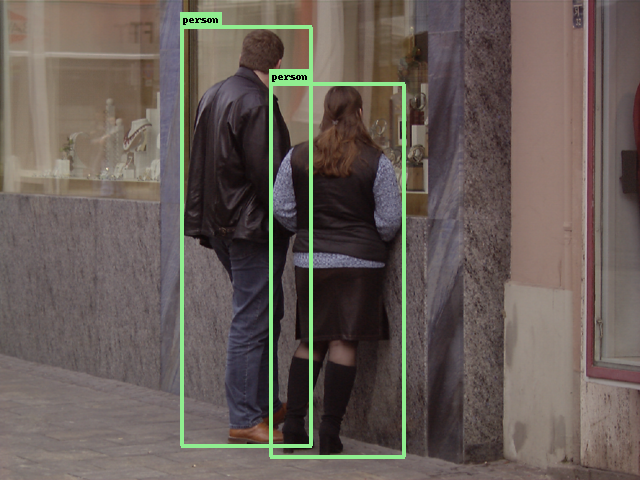

In [7]:
# Render an image 
which_image_to_plot = 25 # Choose an image to render
tc.object_detector.util.draw_bounding_boxes(sf[which_image_to_plot]['image'],
                                            sf[which_image_to_plot]['annotations']).show()